In [9]:
%matplotlib inline

import joblib
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV ,cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from cascid.datasets.pad_ufes.database import get_train_test_metadata, get_df
from cascid.configs.pad_ufes_cnf import PAD_UFES_DIR


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


# Functions

In [10]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Greens, save_to_file = False):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=sorted(classes), yticklabels=sorted(classes),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_to_file:
        plt.savefig(title + '.png')
    return ax

# Data Exploration

In [11]:
database = get_df()

database = database.drop(['img_id','lesion_id'], axis=1)

database.head()

,patient_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,...,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,biopsed
0,PAT_1516,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,...,NaN,NaN,NEV,False,False,False,False,False,False,False
1,PAT_46,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,...,6.0,5.0,BCC,True,True,False,True,True,True,True
2,PAT_1545,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,NaN,...,NaN,NaN,ACK,True,False,False,False,False,False,False
3,PAT_1989,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,NaN,...,NaN,NaN,ACK,True,False,False,False,False,False,False
4,PAT_684,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,...,5.0,5.0,BCC,True,True,False,False,True,True,True


In [12]:
database[['smoke','drink','pesticide','skin_cancer_history','cancer_history','has_piped_water','has_sewage_system','itch','grew','hurt','changed','bleed','elevation','biopsed']] = database[['smoke','drink','pesticide','skin_cancer_history','cancer_history','has_piped_water','has_sewage_system','itch','grew','hurt','changed','bleed','elevation','biopsed']].astype("bool")

database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           2298 non-null   object 
 1   smoke                2298 non-null   bool   
 2   drink                2298 non-null   bool   
 3   background_father    1480 non-null   object 
 4   background_mother    1476 non-null   object 
 5   age                  2298 non-null   int64  
 6   pesticide            2298 non-null   bool   
 7   gender               1494 non-null   object 
 8   skin_cancer_history  2298 non-null   bool   
 9   cancer_history       2298 non-null   bool   
 10  has_piped_water      2298 non-null   bool   
 11  has_sewage_system    2298 non-null   bool   
 12  fitspatrick          1494 non-null   float64
 13  region               2298 non-null   object 
 14  diameter_1           1494 non-null   float64
 15  diameter_2           1494 non-null   f

In [13]:
database = database.drop_duplicates()

database.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1846 entries, 0 to 2297
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           1846 non-null   object 
 1   smoke                1846 non-null   bool   
 2   drink                1846 non-null   bool   
 3   background_father    1159 non-null   object 
 4   background_mother    1155 non-null   object 
 5   age                  1846 non-null   int64  
 6   pesticide            1846 non-null   bool   
 7   gender               1169 non-null   object 
 8   skin_cancer_history  1846 non-null   bool   
 9   cancer_history       1846 non-null   bool   
 10  has_piped_water      1846 non-null   bool   
 11  has_sewage_system    1846 non-null   bool   
 12  fitspatrick          1169 non-null   float64
 13  region               1846 non-null   object 
 14  diameter_1           1169 non-null   float64
 15  diameter_2           1169 non-null   f

In [14]:
df_n = database.copy()
df_n = df_n.fillna("n/a")
df_n.head()

,patient_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,...,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,biopsed
0,PAT_1516,True,True,n/a,n/a,8,True,n/a,True,True,...,n/a,n/a,NEV,True,True,True,True,True,True,False
1,PAT_46,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,...,6.0,5.0,BCC,True,True,True,True,True,True,True
2,PAT_1545,True,True,n/a,n/a,77,True,n/a,True,True,...,n/a,n/a,ACK,True,True,True,True,True,True,False
3,PAT_1989,True,True,n/a,n/a,75,True,n/a,True,True,...,n/a,n/a,ACK,True,True,True,True,True,True,False
4,PAT_684,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,...,5.0,5.0,BCC,True,True,True,True,True,True,True


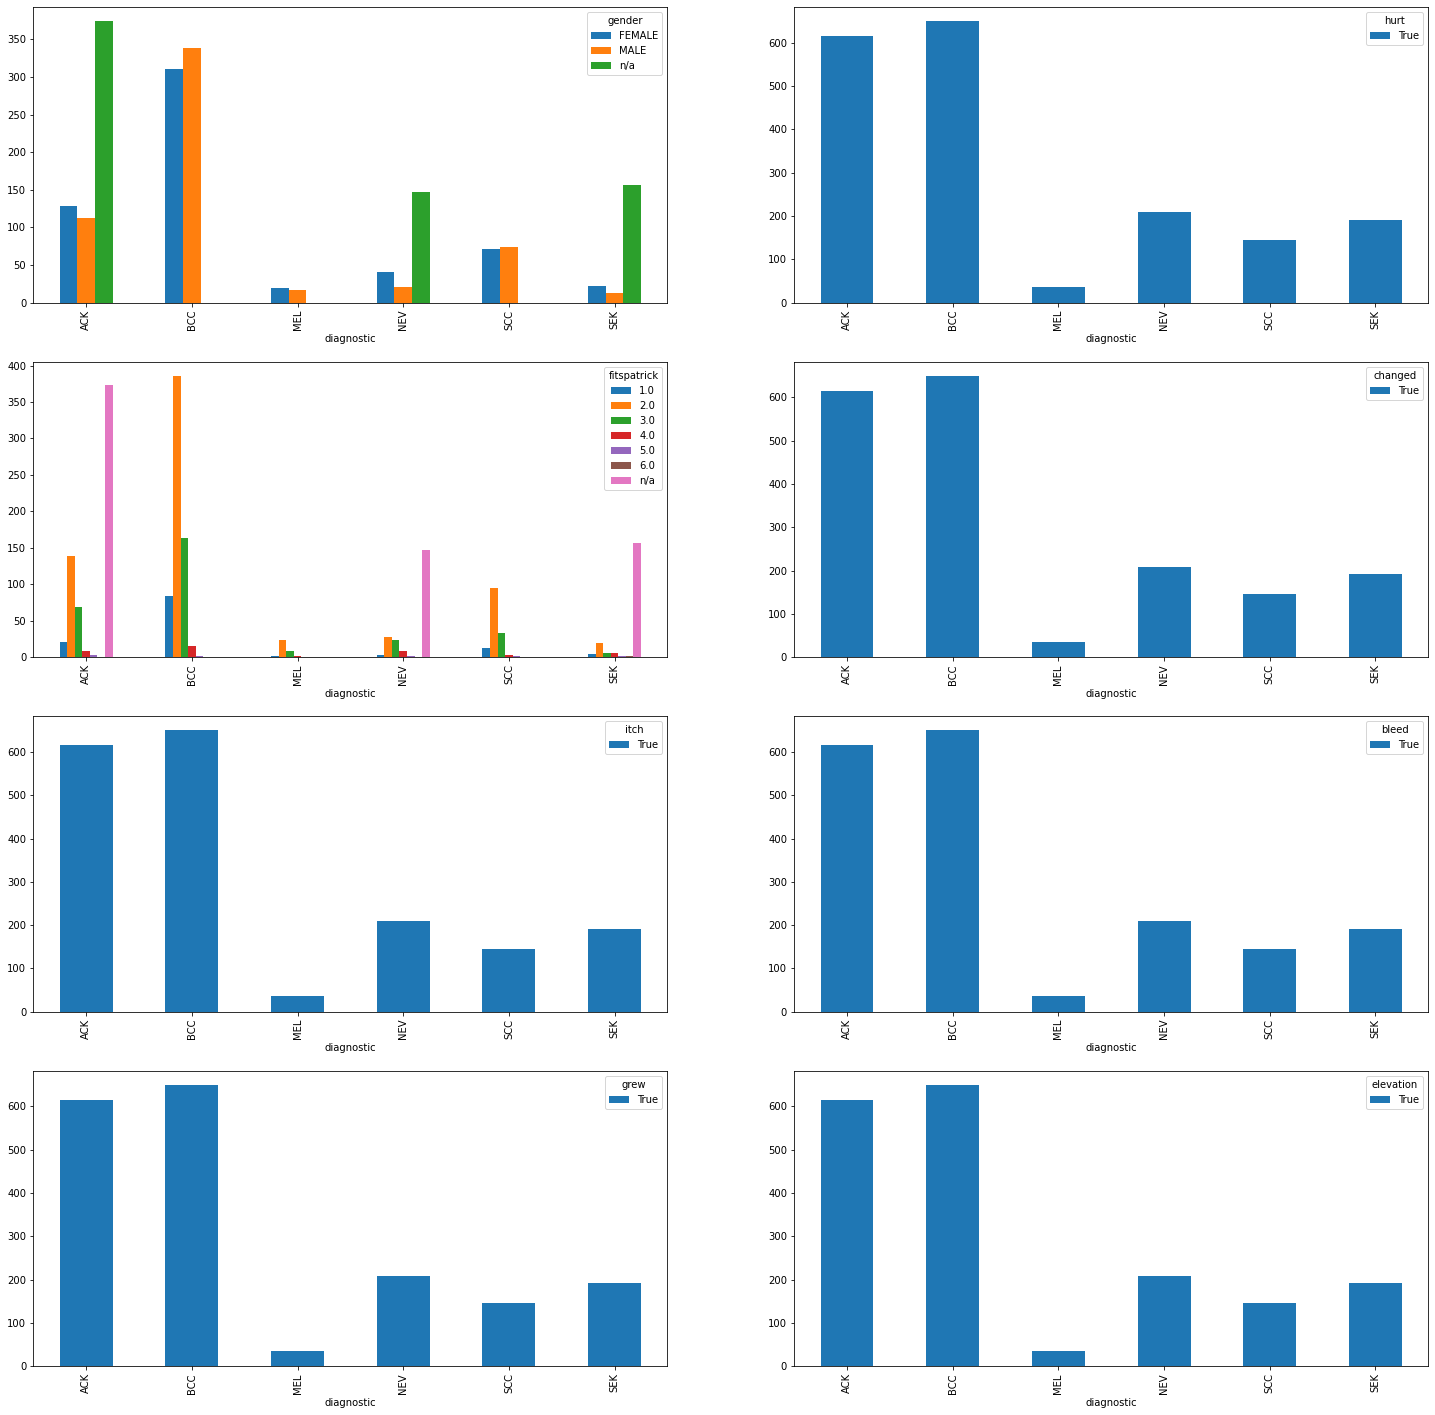

In [15]:
# import pylab
# params = {'legend.fontsize': 20,
#           'legend.handlelength': 2,
#           'axes.labelsize': 20,}

# pylab.rcParams.update(params)

columns = ['gender','fitspatrick', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation']

fig, axes = plt.subplots(4, 2, figsize=(25,25))

i=-1
i2=0

for e in columns:
    i+=1
    if int(i % 4) == 0 and i !=0:
        i2+=1
        i=0
    ct = pd.crosstab(index = df_n['diagnostic'], columns = df_n[e])
    
    ct.plot(kind = "bar",ax=axes[i,i2])

In [16]:
df = database.copy()

df = df.sort_values('diameter_1', ascending=False).groupby('patient_id').first().reset_index()

df.head()

,patient_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,...,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,biopsed
0,PAT_10,True,False,GERMANY,GERMANY,69,False,MALE,False,False,...,13.0,9.0,SCC,True,True,True,True,True,True,True
1,PAT_100,False,False,POMERANIA,POMERANIA,14,False,MALE,False,True,...,7.0,3.0,NEV,True,True,True,True,True,True,True
2,PAT_1000,True,True,None,None,65,True,None,True,True,...,NaN,NaN,SEK,True,True,True,True,True,True,False
3,PAT_1006,True,True,None,None,63,True,None,True,True,...,NaN,NaN,ACK,True,True,True,True,True,True,False
4,PAT_1008,True,True,None,None,64,True,None,True,True,...,NaN,NaN,SEK,True,True,True,True,True,True,False


In [17]:
selected_columns = ['smoke', 'drink', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'age','region','pesticide','diagnostic']

df = df[selected_columns].copy()

df['region'] = df['region'].apply(lambda x: 'OUTROS' if x in ['THIGH','LIP','FOOT','ABDOMEN','SCALP'] else x)

df['is_cancer'] = df['diagnostic'].apply(lambda x: 0 if x in ['ACK','NEV','SEK'] else 1)

df.head()

,smoke,drink,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,age,region,pesticide,diagnostic,is_cancer
0,True,False,False,False,True,False,69,ARM,False,SCC,1
1,False,False,False,True,False,False,14,FACE,False,NEV,0
2,True,True,True,True,True,True,65,EAR,True,SEK,0
3,True,True,True,True,True,True,63,FOREARM,True,ACK,0
4,True,True,True,True,True,True,64,FACE,True,SEK,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1373 entries, 0 to 1372
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   smoke                1373 non-null   bool  
 1   drink                1373 non-null   bool  
 2   skin_cancer_history  1373 non-null   bool  
 3   cancer_history       1373 non-null   bool  
 4   has_piped_water      1373 non-null   bool  
 5   has_sewage_system    1373 non-null   bool  
 6   age                  1373 non-null   int64 
 7   region               1373 non-null   object
 8   pesticide            1373 non-null   bool  
 9   diagnostic           1373 non-null   object
 10  is_cancer            1373 non-null   int64 
dtypes: bool(7), int64(2), object(2)
memory usage: 52.4+ KB


In [19]:
transformer = make_column_transformer((OneHotEncoder(categories='auto'), ['region']), remainder='passthrough')

transformed = transformer.fit_transform(df)

transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names())

transformed_df.head().transpose()

,0,1,2,3,4
onehotencoder__x0_ARM,1.0,0.0,0.0,0.0,0.0
onehotencoder__x0_BACK,0.0,0.0,0.0,0.0,0.0
onehotencoder__x0_CHEST,0.0,0.0,0.0,0.0,0.0
onehotencoder__x0_EAR,0.0,0.0,1.0,0.0,0.0
onehotencoder__x0_FACE,0.0,1.0,0.0,0.0,1.0
onehotencoder__x0_FOREARM,0.0,0.0,0.0,1.0,0.0
onehotencoder__x0_HAND,0.0,0.0,0.0,0.0,0.0
onehotencoder__x0_NECK,0.0,0.0,0.0,0.0,0.0
onehotencoder__x0_NOSE,0.0,0.0,0.0,0.0,0.0
onehotencoder__x0_OUTROS,0.0,0.0,0.0,0.0,0.0


# Train Test Split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    transformed_df.drop(['is_cancer', 'diagnostic'], axis=1),
    transformed_df['diagnostic'],
    test_size = 0.2,
    random_state=RANDOM_SEED,
)

x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(
    transformed_df.drop(['is_cancer', 'diagnostic'], axis=1),
    transformed_df['is_cancer'],
    test_size = 0.2,
    random_state=RANDOM_SEED,
)
y_train_bin = y_train_bin.astype(np.float64)
y_test_bin = y_test_bin.astype(np.float64)

print(f"{x_train.shape=}")
print(f"{x_test.shape=}")
print(f"{y_train.shape=}")
print(f"{y_test.shape=}")
print(f"{x_train_bin.shape=}")
print(f"{x_test_bin.shape=}")
print(f"{y_train_bin.shape=}")
print(f"{y_test_bin.shape=}")

x_train.shape=(1098, 18)
x_test.shape=(275, 18)
y_train.shape=(1098,)
y_test.shape=(275,)
x_train_bin.shape=(1098, 18)
x_test_bin.shape=(275, 18)
y_train_bin.shape=(1098,)
y_test_bin.shape=(275,)


# Predict

In [21]:
def eval_model(model, x_test, y_test, title, *, classes=None):
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:,1]
    if classes:
        classes_list = classes
    else:
        classes_list = list(set(y_test))
    plot_confusion_matrix(y_test, y_pred, classes_list, normalize=True, title=title, save_to_file=True)

Text(0, 0.5, '')

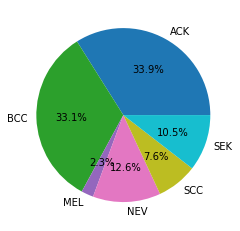

In [22]:
def pct_format(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%".format(pct, absolute)

cnts = (y_train.value_counts()+y_test.value_counts())
ax = cnts.plot(kind="pie",cmap="tab10", autopct=lambda pct: pct_format(pct, cnts))
# ax.legend(title='Classe',title_fontsize=20,loc='center left', bbox_to_anchor=(1.15, 0.5))
ax.set_ylabel("")

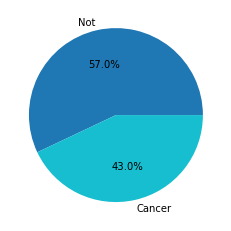

In [23]:
cnts = (y_train_bin.value_counts()+y_test_bin.value_counts())
cnts = cnts.set_axis(["Not", "Cancer"])
ax = cnts.plot(kind="pie",cmap="tab10", autopct=lambda pct: pct_format(pct, cnts))
# ax.legend(title='Classe',title_fontsize=20,loc='center left', bbox_to_anchor=(1.15, 0.5))
ax.set_ylabel("");

# Logistic Regression

Multinomial Log Reg
Model accuracy on train: 0.6302367941712205
Model accuracy on test: 0.6509794553272813

Binary Log Reg
Model accuracy on train: 0.7914389799635702
Model accuracy on test: 0.8254100971492276


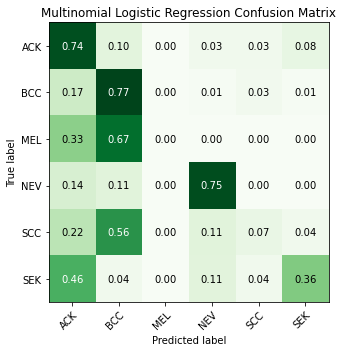

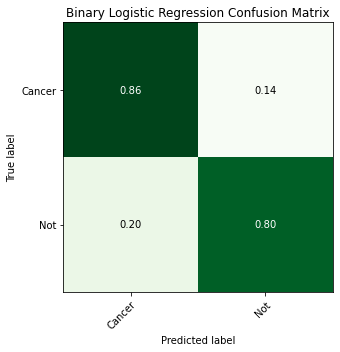

In [24]:
print("Multinomial Log Reg")
log_reg = LogisticRegression(random_state=RANDOM_SEED, max_iter=1e5)
log_reg.fit(x_train, y_train)
eval_model(log_reg, x_test, y_test, title="Multinomial Logistic Regression Confusion Matrix")
tr = cross_val_score(log_reg, x_train, y_train, cv=3, scoring='accuracy')
tst = cross_val_score(log_reg, x_test, y_test, cv=3, scoring='accuracy')
print(f"Model accuracy on train: {tr.mean()}\nModel accuracy on test: {tst.mean()}")

print("\nBinary Log Reg")
log_reg_bin = LogisticRegression(random_state=RANDOM_SEED, max_iter=1e5)
log_reg_bin.fit(x_train_bin, y_train_bin)
eval_model(log_reg_bin, x_test_bin, y_test_bin, title="Binary Logistic Regression Confusion Matrix", classes=["Not", "Cancer"])
tr = cross_val_score(log_reg_bin, x_train_bin, y_train_bin, cv=3, scoring='accuracy')
tst = cross_val_score(log_reg_bin, x_test_bin, y_test_bin, cv=3, scoring='accuracy')
print(f"Model accuracy on train: {tr.mean()}\nModel accuracy on test: {tst.mean()}")

# Random Forest Classifier

Multinomial RFC
Model accuracy on train: 0.5728597449908926
Model accuracy on test: 0.5926501035196687

Binary RFC
Model accuracy on train: 0.8242258652094718
Model accuracy on test: 0.8471492275840102


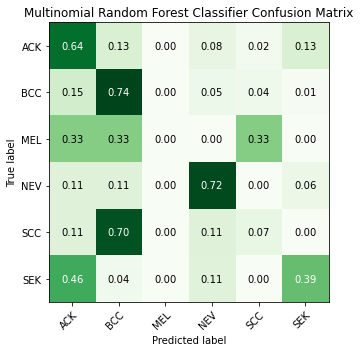

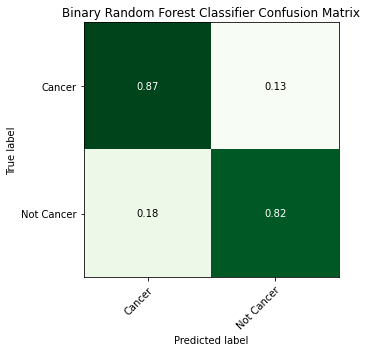

In [25]:
print("Multinomial RFC")
rfc_clf = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=150)
rfc_clf.fit(x_train, y_train)
eval_model(rfc_clf, x_test, y_test, title="Multinomial Random Forest Classifier Confusion Matrix")
tr = cross_val_score(rfc_clf, x_train, y_train, cv=3, scoring='accuracy')
tst = cross_val_score(rfc_clf, x_test, y_test, cv=3, scoring='accuracy')
print(f"Model accuracy on train: {tr.mean()}\nModel accuracy on test: {tst.mean()}")

print("\nBinary RFC")
rfc_clf_bin = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=150)
rfc_clf_bin.fit(x_train_bin, y_train_bin)
eval_model(rfc_clf_bin, x_test_bin, y_test_bin, title="Binary Random Forest Classifier Confusion Matrix", classes=["Not Cancer", "Cancer"])
tr = cross_val_score(rfc_clf, x_train_bin, y_train_bin, cv=3, scoring='accuracy')
tst = cross_val_score(rfc_clf, x_test_bin, y_test_bin, cv=3, scoring='accuracy')
print(f"Model accuracy on train: {tr.mean()}\nModel accuracy on test: {tst.mean()}")

In [26]:
x_test_bin.shape

(275, 18)

# XGBoost

Multinomial XGBoost
Model accuracy on train: 0.5655737704918032
Model accuracy on test: 0.567287784679089

Binary XGBoost
Model accuracy on train: 0.8005464480874317
Model accuracy on test: 0.8218267240006369


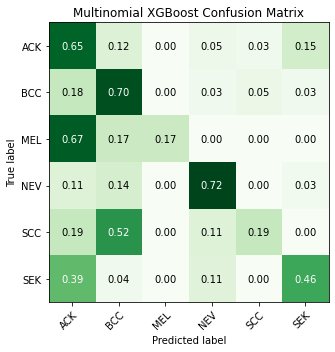

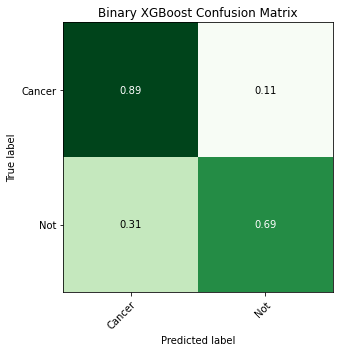

In [27]:
xgb_encoder = OrdinalEncoder()
x_train_xgb = x_train.astype(np.float64)
y_train_xgb = xgb_encoder.fit_transform(y_train.to_numpy().reshape(-1,1))
x_test_xgb = x_test.astype(np.float64)
y_test_xgb = xgb_encoder.transform(y_test.to_numpy().reshape(-1,1))


print("Multinomial XGBoost")
sgb_clf = XGBClassifier(random_state=RANDOM_SEED, n_estimators=110, eval_metric='auc')
sgb_clf.fit(x_train_xgb, y_train_xgb)
y_pred = sgb_clf.predict(x_test_xgb)
y_pred_proba = sgb_clf.predict_proba(x_test_xgb)[:,1]
plot_confusion_matrix(xgb_encoder.inverse_transform(y_test_xgb), xgb_encoder.inverse_transform(y_pred.reshape(-1,1)), sorted(list(set(y_test))), normalize=True, title="Multinomial XGBoost Confusion Matrix", save_to_file=True);
tr = cross_val_score(sgb_clf, x_train_xgb, y_train_xgb, cv=3, scoring='accuracy')
tst = cross_val_score(sgb_clf, x_test_xgb, y_test_xgb, cv=3, scoring='accuracy')
print(f"Model accuracy on train: {tr.mean()}\nModel accuracy on test: {tst.mean()}")

x_train_xgb_bin = x_train_bin.astype(np.float64)
y_train_xgb_bin = xgb_encoder.fit_transform(y_train_bin.to_numpy().reshape(-1,1))
x_test_xgb_bin = x_test_bin.astype(np.float64)
y_test_xgb_bin = xgb_encoder.fit_transform(y_test_bin.to_numpy().reshape(-1,1))

print("\nBinary XGBoost")
sgb_clf_bin = XGBClassifier(random_state=RANDOM_SEED, n_estimators=110, eval_metric='auc')
sgb_clf_bin.fit(x_train_xgb_bin, y_train_bin.to_numpy().reshape(-1,1)) 
y_pred = sgb_clf_bin.predict(x_test_xgb_bin)
y_pred_proba = sgb_clf_bin.predict_proba(x_test_xgb_bin)[:,1]
plot_confusion_matrix(y_test_xgb_bin, y_pred.reshape(-1,1), ["Not", "Cancer"], normalize=True, title="Binary XGBoost Confusion Matrix", save_to_file=True);
tr = cross_val_score(sgb_clf_bin, x_train_xgb_bin, y_train_xgb_bin, cv=3, scoring='accuracy')
tst = cross_val_score(sgb_clf_bin, x_test_xgb_bin, y_test_xgb_bin, cv=3, scoring='accuracy')
print(f"Model accuracy on train: {tr.mean()}\nModel accuracy on test: {tst.mean()}")

# Feature Importances

In [28]:
params = {
    'n_estimators': [h for h in np.arange(50,250,25)],
    'max_features': [k for k in np.arange(1,df.shape[1])]
}
grid = GridSearchCV(rfc_clf_bin,
                    params,
                    cv = 4,
                    scoring='accuracy',
                    return_train_score=True,
                    n_jobs=-1
)

grid.fit(x_train_bin,y_train_bin)

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_estimators=150,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [50, 75, 100, 125, 150, 175, 200,
                                          225]},
             return_train_score=True, scoring='accuracy')

In [29]:
feature_importances = grid.best_estimator_.feature_importances_
importance_list = sorted(zip(feature_importances, x_train_bin.columns.values), reverse=True)
importance_list

[(0.25732534455276607, 'smoke'),
 (0.2118965499748168, 'age'),
 (0.1328235156926911, 'drink'),
 (0.07981917513485666, 'skin_cancer_history'),
 (0.06362129027160175, 'cancer_history'),
 (0.05999156397068682, 'pesticide'),
 (0.05595305148747393, 'has_sewage_system'),
 (0.024644802182441913, 'has_piped_water'),
 (0.01688082226247198, 'onehotencoder__x0_FOREARM'),
 (0.014858324271454658, 'onehotencoder__x0_OUTROS'),
 (0.01391592605436688, 'onehotencoder__x0_FACE'),
 (0.012582530630064589, 'onehotencoder__x0_CHEST'),
 (0.011836519823167512, 'onehotencoder__x0_HAND'),
 (0.011435658943864146, 'onehotencoder__x0_ARM'),
 (0.011161967106345635, 'onehotencoder__x0_NOSE'),
 (0.008607930978896412, 'onehotencoder__x0_BACK'),
 (0.00738516995708554, 'onehotencoder__x0_NECK'),
 (0.005259856704947671, 'onehotencoder__x0_EAR')]

In [30]:
grid.best_params_

{'max_features': 8, 'n_estimators': 125}

In [31]:
grid.best_estimator_

RandomForestClassifier(max_features=8, n_estimators=125, random_state=42)

# Final Model 

In [32]:
x_train_metadata, x_train_stacked, x_test, y_train_metadata, y_train_stacked, y_test = get_train_test_metadata()

In [33]:
params = {
    'n_estimators': [h for h in np.arange(0,50,5)],
    'max_features': [k for k in np.arange(1,df.shape[1])]
}
grid = GridSearchCV(RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=150),
                    params,
                    cv = 4,
                    scoring='roc_auc',
                    return_train_score=True,
                    n_jobs=-1
)

grid.fit(x_train_metadata,y_train_metadata)

c:\Users\samuel.nporto\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.85549401 0.88643238 0.89040783 0.89371525 0.8936819
 0.893667   0.89452578 0.89224396 0.89428429        nan 0.87941266
 0.90216348 0.89930914 0.9017483  0.89846593 0.89786857 0.89898818
 0.89822967 0.89680211        nan 0.87292367 0.88773814 0.88994005
 0.89185485 0.89232762 0.89507868 0.8949492  0.89334395 0.89517976
        nan 0.86161452 0.8784405  0.88461953 0.89039226 0.89087062
 0.89029471 0.89060312 0.88982606 0.89176484        nan 0.87286905
 0.88639586 0.89095239 0.89148183 0.89321117 0.8942999  0.8962133
 0.89377047 0.89346794        nan 0.86744039 0.88534002 0.89287261
 0.89571986 0.89671036 0.89421112 0.89662874 0.89356462 0.89370578
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan   

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_estimators=150,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [0, 5, 10, 15, 20, 25, 30, 35, 40,
                                          45]},
             return_train_score=True, scoring='roc_auc')

In [34]:
grid.best_params_

{'max_features': 2, 'n_estimators': 10}


Binary RFC
Model roc_auc on train: 0.8808911214571591
Model roc_auc on test: 0.8754308390022677


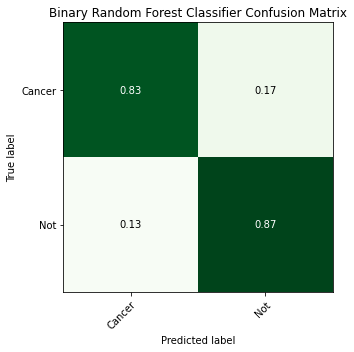

In [35]:
print("\nBinary RFC")
rfc_clf_bin = grid.best_estimator_
rfc_clf_bin.fit(x_train_metadata, y_train_metadata)
eval_model(rfc_clf_bin, x_test, y_test, title="Binary Random Forest Classifier Confusion Matrix", classes=["Not", "Cancer"])
tr = cross_val_score(rfc_clf_bin, x_train_metadata, y_train_metadata, cv=3, scoring='roc_auc')
tst = cross_val_score(rfc_clf_bin, x_test, y_test, cv=3, scoring='roc_auc')
print(f"Model roc_auc on train: {tr.mean()}\nModel roc_auc on test: {tst.mean()}")

In [36]:
joblib.dump(rfc_clf_bin, PAD_UFES_DIR/'rfc_clf_bin_final.joblib')

['C:\\Users\\samuel.nporto\\.cascid_data\\PAD-UFES\\rfc_clf_bin_final.joblib']

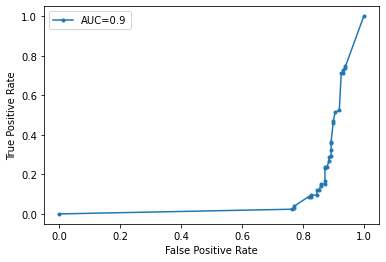

In [37]:
y_pred_proba = rfc_clf_bin.predict_proba(x_test)[::,1]

fpr, tpr, _ = metrics.roc_curve([1 if x == 'Cancer' else 0 for x in y_test],  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr, marker='.', label="AUC="+str(auc.round(2)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()


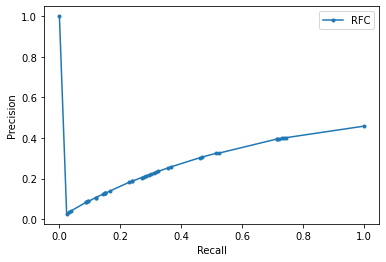

In [38]:
rfc_precision, rfc_recall, _ = metrics.precision_recall_curve([1 if x == 'Cancer' else 0 for x in y_test], y_pred_proba)

plt.plot(rfc_recall, rfc_precision, marker='.', label='RFC')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [39]:
y_pred_train, y_pred_test = rfc_clf_bin.predict(x_train_metadata), rfc_clf_bin.predict(x_test)

In [40]:
print(classification_report(y_train_metadata, y_pred_train, digits = 4))

              precision    recall  f1-score   support

      Cancer     0.9449    0.9654    0.9550       231
         Not     0.9744    0.9591    0.9667       318

    accuracy                         0.9617       549
   macro avg     0.9597    0.9622    0.9609       549
weighted avg     0.9620    0.9617    0.9618       549



In [41]:
print(classification_report(y_test, y_pred_test, digits = 4))
# Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

              precision    recall  f1-score   support

      Cancer     0.8468    0.8333    0.8400       126
         Not     0.8609    0.8725    0.8667       149

    accuracy                         0.8545       275
   macro avg     0.8539    0.8529    0.8533       275
weighted avg     0.8544    0.8545    0.8544       275



In [42]:
def apply_threshold(thr, preds):
    return ["Cancer" if i[0] > thr else "Not" for i in preds]

preds_best_proba = rfc_clf_bin.predict_proba(x_test)

res = list()
for i in np.arange(0.05, 0.87, 0.001):
    rep = classification_report(y_test, apply_threshold(i, preds_best_proba), output_dict=True)
    sens, spec = rep['Cancer']['recall'], rep['Not']['recall']
    res.append([i, sens, spec])
res = np.array(res)

Closest performance to doctor would be:
sensitivity=0.7301587301587301
specificity=0.8859060402684564


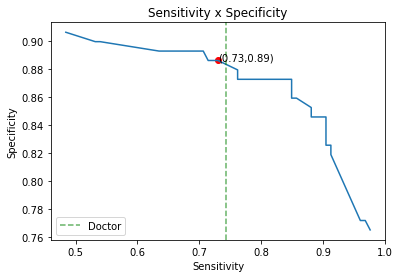

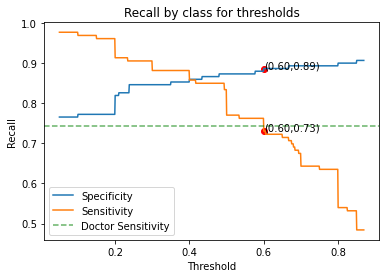

In [43]:
thr = res[:,0]
sensitivity = res[:,1]
specificity = res[:,2]

i = 0
s = sensitivity[i]
while s > 0.734:
    i+=1
    s = sensitivity[i]
print("Closest performance to doctor would be:\nsensitivity={}\nspecificity={}".format(sensitivity[i], specificity[i]))

SIZE=(6,4)
plt.figure(figsize=SIZE)
plt.plot(sensitivity, specificity);
plt.axvline(0.743, label="Doctor", c='g', alpha=0.6, ls='--')
plt.title("Sensitivity x Specificity")
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.scatter(sensitivity[i], specificity[i], c='r')
plt.annotate("({:.2f},{:.2f})".format(sensitivity[i], specificity[i]), (sensitivity[i], specificity[i]))
plt.legend(loc=3)
plt.show()

plt.figure(figsize=SIZE)
plt.plot(thr, specificity,label='Specificity')
plt.plot(thr, sensitivity,label='Sensitivity')
plt.axhline(0.743, label="Doctor Sensitivity", c='g', alpha=0.6, ls='--')
plt.title("Recall by class for thresholds")
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.scatter(thr[i], sensitivity[i], c='r')
plt.scatter(thr[i], specificity[i], c='r')
plt.annotate("({:.2f},{:.2f})".format(thr[i], sensitivity[i]), (thr[i], sensitivity[i]))
plt.annotate("({:.2f},{:.2f})".format(thr[i], specificity[i]), (thr[i], specificity[i]))
plt.legend()
plt.show();



In [44]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
